In [5]:
!pip install wandb
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 47.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 M

In [9]:
# Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
import torch.optim as optim
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl

import torchmetrics

In [11]:
# Set up the WandbLogger
wandb_logger = WandbLogger(log_model="all", project="VOCSegmentation", name='exp1')

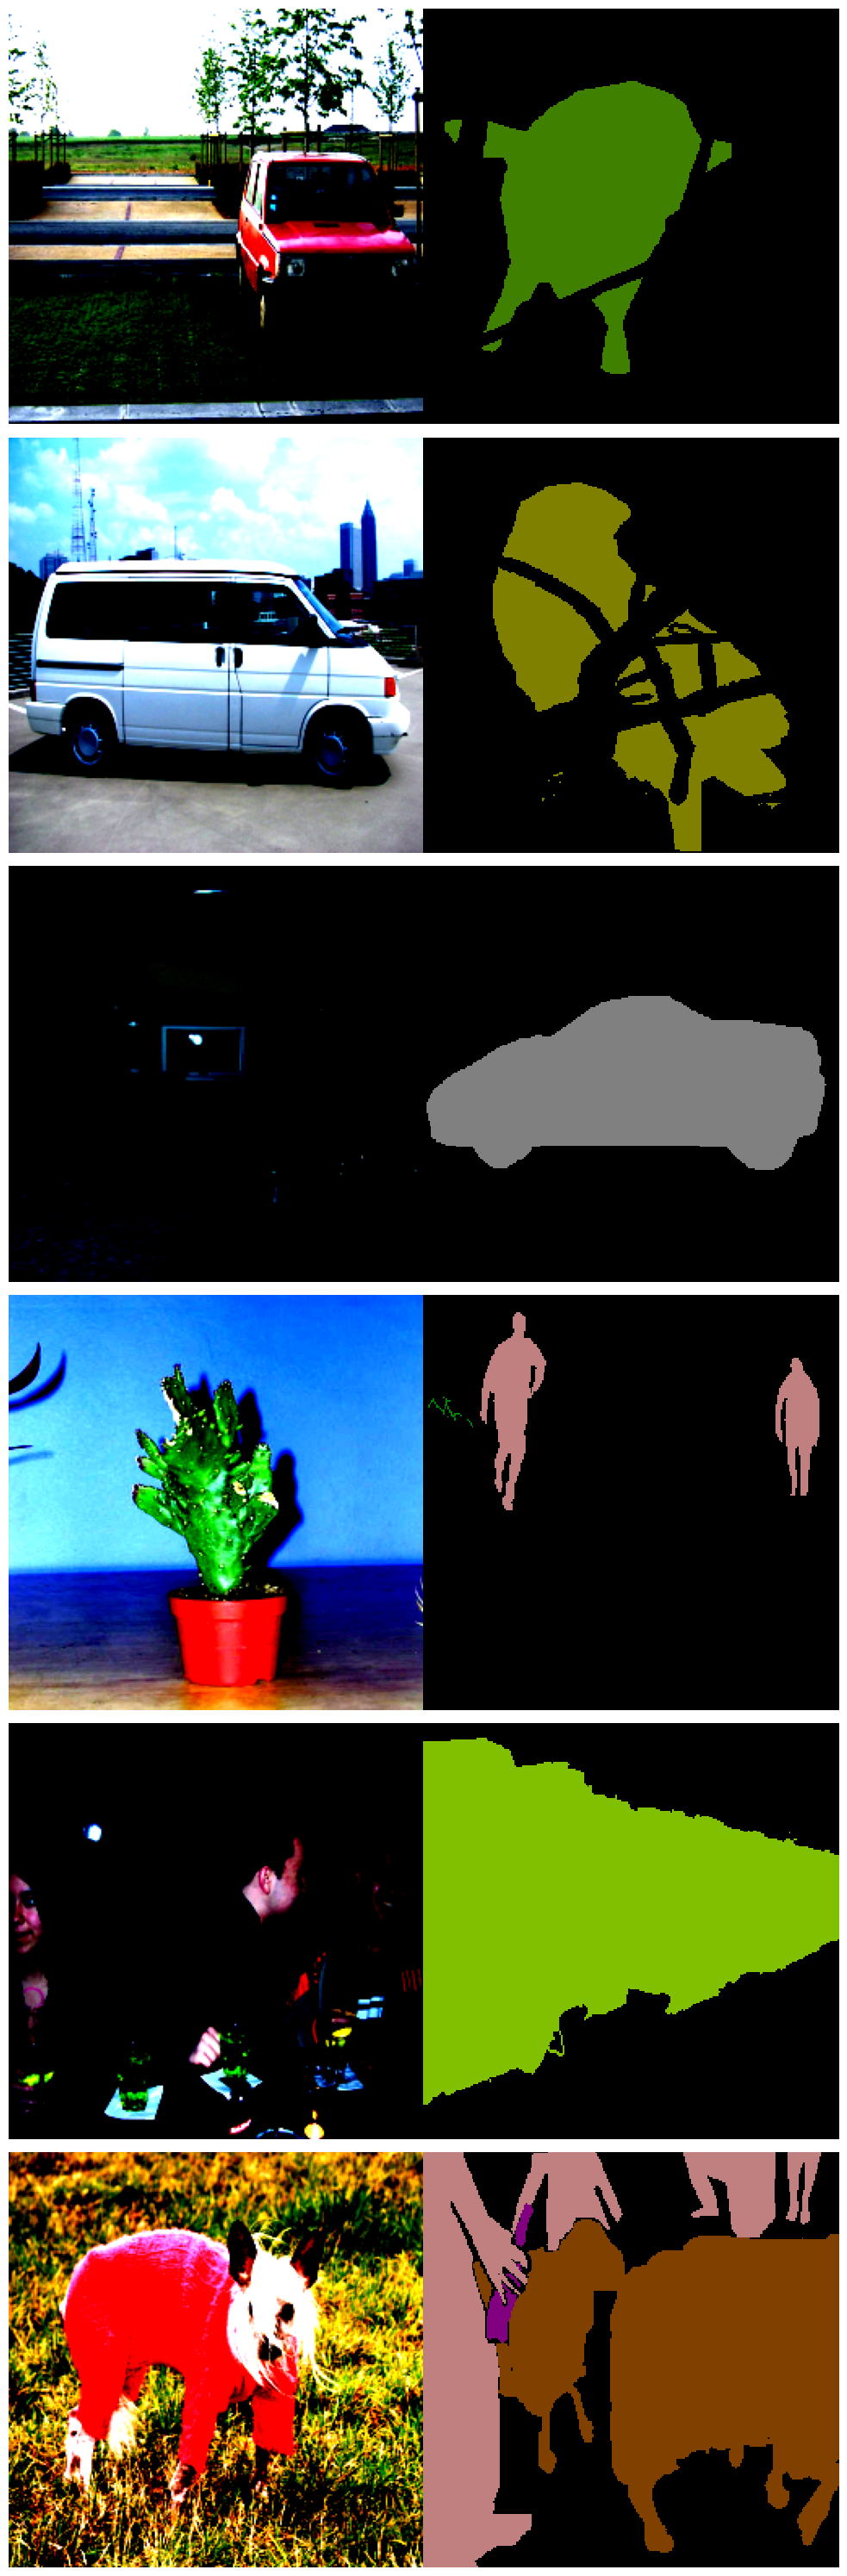

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type             | Params
-------------------------------------------------
0  | criterion  | CrossEntropyLoss | 0     
1  | encoder1   | Conv2d           | 1.8 K 
2  | encoder2   | Conv2d           | 73.9 K
3  | bottleneck | Conv2d           | 221 K 
4  | decoder2   | Conv2d           | 516 K 
5  | decoder1   | Conv2d           | 73.8 K
6  | outconv    | Conv2d           | 1.4 K 
7  | bn1        | BatchNorm2d      | 128   
8  | bn2        | BatchNorm2d      | 256   
9  | bn3        | BatchNorm2d      | 384   
10 | up_trans2  | ConvTranspose2d  | 246 K 
11 | up_trans1  | ConvTranspose2d  | 32.8 K
-------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.672     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
wandb_logger = WandbLogger(log_model="all", project="VOCSegmentation", name='exp1')
# Check if CUDA is available and choose the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# dataset link : https://www.kaggle.com/datasets/sovitrath/voc-2012-segmentation-data
ALL_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike', 'person', 'potted plant',
    'sheep', 'sofa', 'train', 'tv/monitor'
]

LABEL_COLORS_LIST = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128]
]
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=len(ALL_CLASSES)).to(device)

# Normalize colors to range [0, 1]
normalized_colors = [[r / 255, g / 255, b / 255] for r, g, b in LABEL_COLORS_LIST]

# Create colormap
cmap = ListedColormap(normalized_colors)

class VOCDataSet(Dataset):
    def __init__(self, root_dir, dataset_type='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform

        if dataset_type == 'train':
            self.image_folder = os.path.join(root_dir, 'train_images')
            self.label_folder = os.path.join(root_dir, 'train_labels')
        elif dataset_type == 'val':
            self.image_folder = os.path.join(root_dir, 'valid_images')
            self.label_folder = os.path.join(root_dir, 'valid_labels')
        else:
            raise ValueError("Invalid dataset_type. Use 'train' or 'val'.")

        self.image_list = os.listdir(self.image_folder)
        self.label_list = os.listdir(self.label_folder)

    # Convert RGB label to an integer label
    def rgb_to_integer(self, label_rgb):
        label_integer = np.zeros(label_rgb.shape[:2], dtype=np.uint8)
        for i, color in enumerate(LABEL_COLORS_LIST):
            mask = np.all(label_rgb == color, axis=-1)
            label_integer[mask] = i
        return label_integer

    def __len__(self):
        return len(self.image_list)

    # read image and mask for a single image and apply transform
    # be careful with applying transformations on the Mask (it should remain integer)
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        label_name = os.path.join(self.label_folder, self.label_list[idx])
        image = Image.open(img_name)
        label = Image.open(label_name).convert('RGB')
        label_array = np.array(label)
        label_integer = self.rgb_to_integer(label_array)

        if self.transform:
            image = self.transform(image)

        imSize = self.transform.transforms[0].size[0]
        label_integer = (torch.tensor(label_integer).unsqueeze(0)).unsqueeze(0)
        label_integer = F.interpolate(label_integer, size=(imSize, imSize), mode='nearest').squeeze(0).squeeze(0).long()  # only use NN

        return image, label_integer

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a train dataset object
train_dataset = VOCDataSet(root_dir='/content/drive/MyDrive/voc_2012_segmentation_data', dataset_type='train', transform=transform)
# Create a DataLoader for the train dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a validation dataset object
val_dataset = VOCDataSet(root_dir='/content/drive/MyDrive/voc_2012_segmentation_data', dataset_type='val', transform=transform)
# Create a DataLoader for the train dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get a batch of data & display it (just to see we correctly read the dataset!)
images, masks = next(iter(train_loader))
# Display the batch
fig, axs = plt.subplots(6, 2, figsize=(10, 30))
for i in range(6):
    # Display image
    axs[i, 0].imshow(images[i].permute(1, 2, 0))
    axs[i, 0].axis('off')
    # use NN to display exact
    axs[i, 1].imshow(np.squeeze(masks[i]), cmap=cmap, interpolation='nearest', vmin=0, vmax=len(ALL_CLASSES) - 1)
    axs[i, 1].axis('off')
    # axs[i, 1].set_title('Mask')
plt.tight_layout()
plt.show(block=True)

#Custom UNET Model Class
class VOCUNet(pl.LightningModule):
    def __init__(self, in_channels=3, n_classes=21, features=64, learning_rate=1e-3):
        super(VOCUNet, self).__init__()
        self.learning_rate = learning_rate
        self.criterion = nn.CrossEntropyLoss()

        self.encoder1 = nn.Conv2d(in_channels, features, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv2d(features, features * 2, kernel_size=3, padding=1)
        self.bottleneck = nn.Conv2d(features * 2, features * 3, kernel_size=3, padding=1)

        self.decoder2 = nn.Conv2d(features * 5 + features * 2, features * 2, kernel_size=3, padding=1)

        # Adjust the input channels for decoder1 to match concatenated channels
        self.decoder1 = nn.Conv2d(features + features, features, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(features, n_classes, kernel_size=1)

        self.bn1 = nn.BatchNorm2d(features)
        self.bn2 = nn.BatchNorm2d(features * 2)
        self.bn3 = nn.BatchNorm2d(features * 3)

        # Transpose convolutions for upsampling
        self.up_trans2 = nn.ConvTranspose2d(features * 3, features * 5, kernel_size=2, stride=2)
        self.up_trans1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder Path
        x1 = self.encoder1(x)
        x1 = self.bn1(x1)
        x1 = nn.ReLU()(x1)
        x = nn.MaxPool2d(2, stride=2)(x1)
        x2 = self.encoder2(x)
        x2 = self.bn2(x2)
        x2 = nn.ReLU()(x2)

        # Bottleneck
        x = nn.MaxPool2d(2, stride=2)(x2)
        x = self.bottleneck(x)
        x = self.bn3(x)
        x = nn.ReLU()(x)

        # Decoder Path
        x = self.up_trans2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.decoder2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)

        x = self.up_trans1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.decoder1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)

        y = self.outconv(x)

        return y


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        softmaxed_logits = torch.softmax(logits, dim=1)  # Apply softmax along the class dimension
        # Get the integer mask by taking the argmax along the class dimension
        predicted_mask = torch.argmax(softmaxed_logits, dim=1)

        iou=jaccard(predicted_mask, y)
        self.log('train/iou', iou,on_epoch=True,on_step=True,prog_bar=True)

        if(batch_idx==0):
             #Display the batch
            fig, axs = plt.subplots(6, 3, figsize=(10, 30))
            for i in range(6):
                # Display image
                axs[i, 0].imshow(x[i].cpu().detach().permute(1, 2, 0),vmin=torch.min(x[i]),vmax=torch.max(x[i]))
                axs[i, 0].axis('off')
                # Display mask
                #use NN to display exact
                axs[i, 1].imshow(y[i].cpu().detach(),cmap=cmap,interpolation='nearest',vmin=0, vmax=len(ALL_CLASSES)-1)
                axs[i, 1].axis('off')

                axs[i, 2].imshow(predicted_mask[i].cpu().detach(),cmap=cmap,interpolation='nearest',vmin=0, vmax=len(ALL_CLASSES)-1)
                axs[i, 2].axis('off')
            plt.tight_layout()
            fig = plt.gcf()
            fig.canvas.draw()
            data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            # Log images
            wandb_logger.log_image(key="Train_Images", images=[data],caption=[f"Image-{self.trainer.current_epoch}"])



        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        softmaxed_logits = torch.softmax(logits, dim=1)  # Apply softmax along the class dimension
        # Get the integer mask by taking the argmax along the class dimension
        predicted_mask = torch.argmax(softmaxed_logits, dim=1)

        iou=jaccard(predicted_mask, y)
        self.log('val/iou', iou,on_epoch=True,on_step=True,prog_bar=True)

        if(batch_idx==0):
             #Display the batch
            fig, axs = plt.subplots(6, 3, figsize=(10, 30))
            for i in range(6):
                # Display image
                axs[i, 0].imshow(x[i].cpu().detach().permute(1, 2, 0),vmin=torch.min(x[i]),vmax=torch.max(x[i]))
                axs[i, 0].axis('off')
                # Display mask
                #use NN to display exact
                axs[i, 1].imshow(y[i].cpu().detach(),cmap=cmap,interpolation='nearest',vmin=0, vmax=len(ALL_CLASSES)-1)
                axs[i, 1].axis('off')

                axs[i, 2].imshow(predicted_mask[i].cpu().detach(),cmap=cmap,interpolation='nearest',vmin=0, vmax=len(ALL_CLASSES)-1)
                axs[i, 2].axis('off')
            plt.tight_layout()


            fig = plt.gcf()
            fig.canvas.draw()
            data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            plt.close()

            # Log images
            wandb_logger.log_image(key="Val_Images", images=[data],caption=[f"Image-{self.trainer.current_epoch}"])




        return loss
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def configure_callbacks(self):
        """Configures the ModelCheckpoint callback."""
        checkpoint_callback = ModelCheckpoint(
            monitor='val/iou',  # Monitor validation accuracy
            dirpath='./checkpoints',  # Directory to save checkpoints
            filename='best_model',  # Filename pattern
            save_top_k=1,  # Save only the best model
            mode='max',  # Save model with highest accuracy
            verbose=True
        )
        return [checkpoint_callback]  # Return a list of callbacks


# Train the model
model = VOCUNet()
callbacks = model.configure_callbacks()

trainer = pl.Trainer(logger=wandb_logger,max_epochs=50, devices=1, accelerator="auto",callbacks=callbacks)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)